# DistilBert

### Import necessary packages

In [1]:
import numpy as np
import mlflow
import logging 
import torch 
import torch.nn as nn
import config 
import os 
from mlflow.sklearn import save_model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, AutoModel, PreTrainedModel

import mlflow.pytorch
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # This tells Hugging Face: “Don’t use parallel tokenization — avoid possible deadlocks.”

/Users/maren/Library/CloudStorage/OneDrive-Persönlich/Dokumente/neue_fische/Capstone Project/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from basic_functions import(
    get_encode_tokenize_data,
    createTrainer,
    get_eval_metrics,
    
)

### Setup

In [3]:
MODEL_NAME = "Distilbert Binary Multiclass" # pulls the general-purpose DistilBERT model
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [4]:
# DATA_PATH = "../data/data_small.csv"
DATA_PATH = "../data/data_multiclass_with_none.csv" # uncomment this when checking that everything is just running properly. 
MODEL_PATH = "distilbert-base-uncased"
MODEL_TRAINING_PATH ="distilbert-base-uncased"
LOAD_PATH = "../models/distilbert_binary/pytorch_model" # change this path for loading the model
OUTPUT_DIR = "../models/distilbert_binary_multiclass/trainer_output"
SAVE_PATH = "../models/distilbert_binary_multiclass/pytorch_model"

### Get data

In [5]:
# use "binary" for binary classification and "multiclass" for multiclass classification
train_dataset, test_dataset, encoded_train_dataset, encoded_test_dataset, le = get_encode_tokenize_data("multiclass", DATA_PATH, MODEL_PATH)

INFO:basic_functions:Loading data...
INFO:basic_functions:Train test split, test-size 0.3
INFO:root:Create encoded dataframes
INFO:root:Encode the label column
INFO:root:Tokenize
INFO:basic_functions:create tokenizer & load model
INFO:basic_functions:create tokenizer & load model
INFO:root:Create TextDatasets (train & test)


In [6]:
y_train = encoded_train_dataset['logical_fallacies']

### Model Initialization

In [7]:
learning_rate= 3e-5
weight_decay= 0.01
num_train_epochs= 4
evaluation_strategy= 'epoch'
class_weight = False
dropout= 0.3


params = {
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "num_train_epochs": num_train_epochs,
      "evaluation_strategy": evaluation_strategy,
      "dropout": dropout,
      "dataset": DATA_PATH
  }


# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "Distilbert Binary Multiclass")
mlflow.log_params(params)

Active run_id: 4ac5a8518abb4746807546e3a1b0ba90


### Load model

In [8]:
# Load model saved with mlflow
model = mlflow.pytorch.load_model(LOAD_PATH)


In [9]:
# Manually create new config with 6 classes

num_classes = len(np.unique(y_train))

config = AutoConfig.from_pretrained(MODEL_TRAINING_PATH)
config.num_labels = num_classes

In [10]:
# reinit model with the new config
reinit_model = AutoModelForSequenceClassification.from_pretrained(MODEL_TRAINING_PATH, config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# model.base_model refers to the base transformer (e.g., DistilBERT encoder) of loaded model
# reinit_model.base_model is the base transformer of  new multiclass model

reinit_model.base_model.load_state_dict(model.base_model.state_dict(), strict=False)

<All keys matched successfully>

In [12]:
trainer = createTrainer(
    model=reinit_model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    output_dir=OUTPUT_DIR,
    y_train=y_train,
    class_weight=class_weight,
    epochs=num_train_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    train_batch_size=4,
    eval_batch_size=8
)

INFO:root:defining training arguments
INFO:root:get normal trainer


### Execute Training

In [13]:
torch.mps.empty_cache()  # Clears unused GPU memory

In [14]:
# disable upper limit for memory
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# Allows up to 100% of available memory
torch.mps.set_per_process_memory_fraction(1.0)  

In [15]:
logger.info('training is running')
trainer.train()

INFO:root:training is running


Epoch,Training Loss,Validation Loss,Accuracy
1,0.978600,0.868029,0.708333
2,0.562200,1.053680,0.713542
3,0.274200,1.215637,0.739583
4,0.211000,1.314680,0.727083


TrainOutput(global_step=2240, training_loss=0.5521012095468385, metrics={'train_runtime': 833.7028, 'train_samples_per_second': 10.747, 'train_steps_per_second': 2.687, 'total_flos': 1186992559226880.0, 'train_loss': 0.5521012095468385, 'epoch': 4.0})

### Evaluation (might not be correct, as model has seen some sentences before)


In [16]:
def log_metrics(cr, brier, split):
    mlflow.log_metric(f"{split}_brier", brier)

    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

    

INFO:root:predict on test_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.60      0.67      0.63       162
appeal_to_authority       0.69      0.78      0.73       143
  appeal_to_emotion       0.71      0.57      0.63       174
      false_dilemma       0.95      0.57      0.71       163
               none       0.68      0.81      0.74       160
     slippery_slope       0.73      0.88      0.80       158

           accuracy                           0.71       960
          macro avg       0.73      0.71      0.71       960
       weighted avg       0.73      0.71      0.71       960



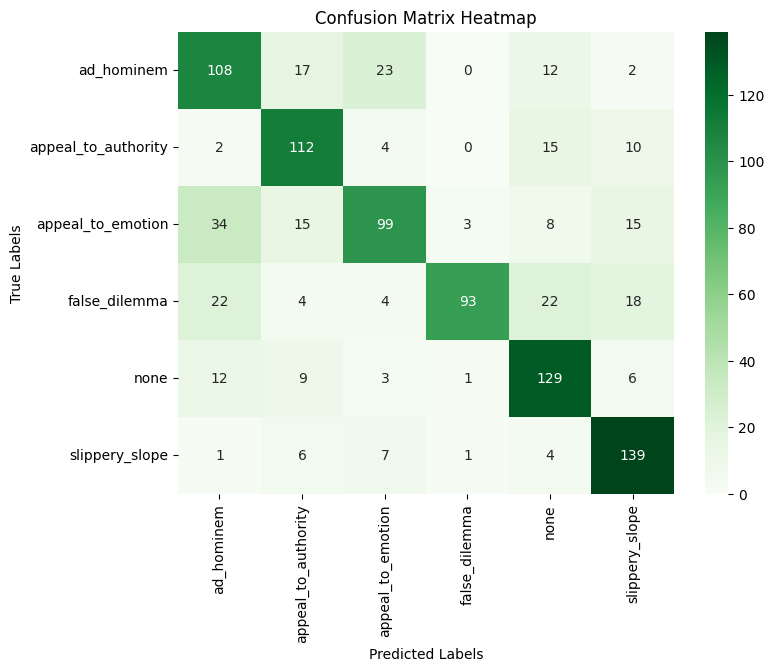

INFO:basic_functions:brier score


Multiclass Brier score: 0.41669075918148496


In [17]:
logger.info('predict on test_dataset')
test_output = trainer.predict(test_dataset)

classification_report, brier = get_eval_metrics(test_output, le)
log_metrics(classification_report, brier, "test")


INFO:root:predict on train_dataset


INFO:basic_functions:get evaluation metrics
INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.75      0.81      0.78       380
appeal_to_authority       0.76      0.79      0.78       333
  appeal_to_emotion       0.86      0.73      0.79       405
      false_dilemma       0.97      0.71      0.82       380
               none       0.76      0.91      0.83       373
     slippery_slope       0.84      0.95      0.89       369

           accuracy                           0.81      2240
          macro avg       0.82      0.82      0.81      2240
       weighted avg       0.82      0.81      0.81      2240



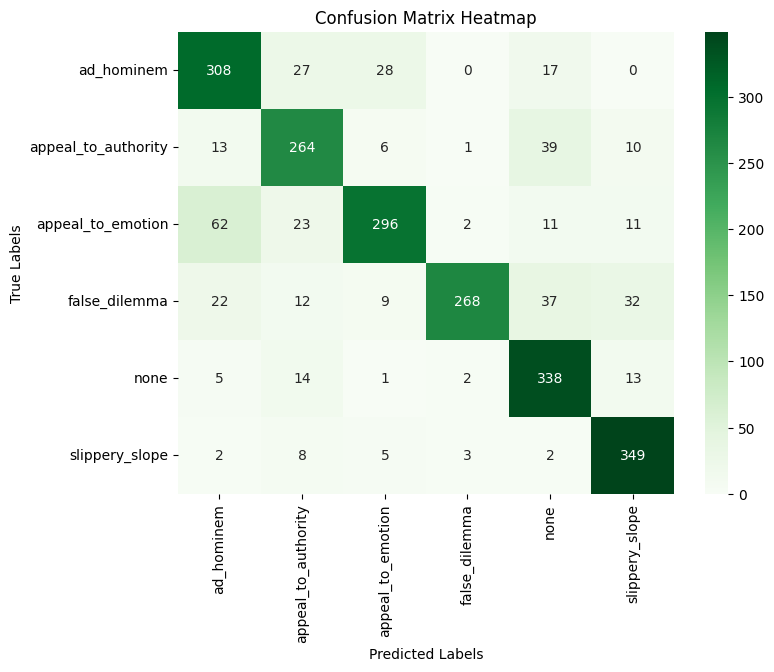

INFO:basic_functions:brier score


Multiclass Brier score: 0.27032632955271363


In [18]:
logger.info('predict on train_dataset')
train_output = trainer.predict(train_dataset)

classification_report, brier= get_eval_metrics(train_output, le)
log_metrics(classification_report, brier, "train")


In [19]:
mlflow.end_run()

🏃 View run Distilbert Binary Multiclass at: http://127.0.0.1:5001/#/experiments/823412171152425451/runs/4ac5a8518abb4746807546e3a1b0ba90
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/823412171152425451


### Save model

In [60]:
mlflow.pytorch.save_model(reinit_model, path=SAVE_PATH)

### Evaluation on dataset that model has not seen

In [101]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [102]:
from basic_functions import (
    tokenize,
    get_metrics
)

In [103]:
DATA_PATH_VAL = '../data/data_val.csv'

In [104]:
df = pd.read_csv(DATA_PATH_VAL)

In [105]:
#load model
path_pt = "../models/distilbert_binary_multiclass/pytorch_model"
model_reload = mlflow.pytorch.load_model(path_pt)

In [106]:
print(f"Number of labels in model config: {model_reload.config.num_labels}")

Number of labels in model config: 6


In [107]:
print("Classifier type:", type(model_reload.classifier))
if hasattr(model_reload.classifier, 'out_features'):
    print("Classifier out_features:", model_reload.classifier.out_features)
else:
    print("Classifier has no 'out_features' attribute.")
print("Config num_labels:", model_reload.config.num_labels)

Classifier type: <class 'torch.nn.modules.linear.Linear'>
Classifier out_features: 6
Config num_labels: 6


In [108]:
def get_tokenized_text(df):
    X = df['text']
    x_tokenized = tokenize(X.to_list(), "distilbert-base-uncased")
    return x_tokenized

In [109]:
df_tokenized = get_tokenized_text(df)

INFO:basic_functions:create tokenizer & load model


In [110]:
def predict(model, encodings, batch_size=8):
    # Set the model to evaluation mode
    model.eval()
    
    # Use GPU
    device = torch.device("mps")
    model.to(device)
    
    # Perform inference
    probabilities = []
    for i in range(0, len(encodings["input_ids"]), batch_size):
        with torch.no_grad():
            batch = {
                key: val[i:i+batch_size].to(device) 
                for key, val in encodings.items()
            }
            outputs = model(**batch)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            probabilities.extend(probs)
            
        # Clear GPU memory after each batch
        torch.mps.empty_cache()
    
    return np.array(probabilities)

In [111]:
base_probs = predict(model_reload, df_tokenized, batch_size=2)

In [112]:
def get_first_prediction(proba):
    preds = np.argmax(proba, axis=1)
    probas = proba[np.arange(len(preds)), preds]
    return preds, probas

In [113]:
predicted_labels, predicted_proba = get_first_prediction(base_probs)

In [114]:
#get encodings
df_encodings = pd.read_csv('../data/data_multiclass_with_none.csv')
y = df_encodings["logical_fallacies"]
le = LabelEncoder()
y_train = le.fit(y)

In [115]:
df['pred'] = predicted_labels

In [116]:
df['pred'] = le.inverse_transform(df['pred'])

INFO:basic_functions:classification_report
INFO:basic_functions:confusion_matrix
INFO:basic_functions:heatmap


                     precision    recall  f1-score   support

         ad_hominem       0.64      0.66      0.65       250
appeal_to_authority       0.65      0.70      0.68       250
  appeal_to_emotion       0.76      0.55      0.64       250
      false_dilemma       0.91      0.60      0.72       250
               none       0.54      0.73      0.62       250
     slippery_slope       0.59      0.80      0.68       100

           accuracy                           0.66      1350
          macro avg       0.68      0.67      0.66      1350
       weighted avg       0.69      0.66      0.66      1350

[[166  33  22   1  28   0]
 [ 17 176   7   3  37  10]
 [ 48  21 137   2  34   8]
 [ 17  10   6 149  52  16]
 [ 11  22   7   6 182  22]
 [  2   7   2   3   6  80]]


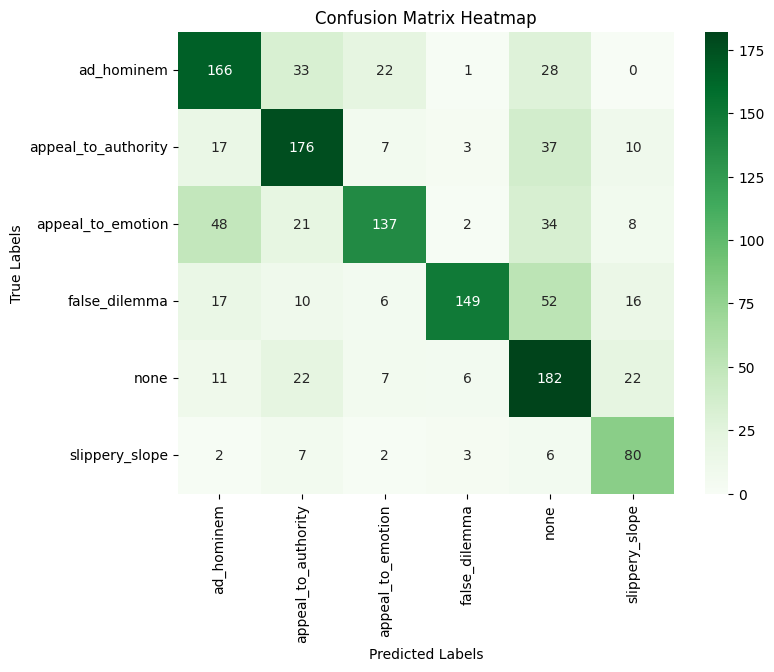

In [117]:
classification_report_one_train = get_metrics(df['logical_fallacies'], df['pred'])